# Understanding out-of-sample behavior for traffic sign detection

We demonstrated how to discover out-of-sample behavior using semantic transformations on images.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import scipy as scp
import skimage
import os, sys
import matplotlib.pyplot as plt
from skimage.filters import gaussian

sys.path.append(os.path.join('..'))
from scripts.data_utils_sign import *
from scripts.train_sign_detector import cnn_model, train, test
from adp.curve import * 
from adp.utility import *
from adp.plot import *
from adp.funcs import *
from adp.optim import *
from keras.models import Model

Using TensorFlow backend.


In [2]:
# Load data
x_train, y_train, x_test, y_test = get_data(root='../data/', name='GTSRB')

# Train the model. Load a pre-trained model when it is available.
NUM_CLASSES = np.unique(y_train).shape[0]
target = np.eye(NUM_CLASSES, dtype='uint8')[y_train]
if os.path.exists('../models/traffic_model.h5'):
    print('==>Pre-trained model found to load.')
    cnn_base = train(cnn_model(IMG_SIZE, NUM_CLASSES), x_train, target,
                     model_name='../models/traffic_model', load=True)
else:
    if not os.path.exists('../models'):
        os.mkdir('../models')
    print('==>Pre-trained model not found. Training a new one...')
    cnn_base = train(cnn_model(IMG_SIZE, NUM_CLASSES), x_train, target,
                     model_name='../models/traffic_model', load=False)
test_acc = test(cnn_base, x_test, y_test)

Loading pre-processed data.
==>Pre-trained model found to load.
Test accuracy = 0.896437054631829


In [3]:
# Select a stop sign to evaluate
# stop sign has a class label 14
class_label = 14
idx = np.where(y_test == class_label)[0]
predictions = cnn_base.predict_classes(x_test[idx])

# stop sign index 167
test_idx = 167
x0 = x_test[test_idx]

# wrapper for getting the presoftmax output
def model(X):
    # get presoftmax output
    presoft = Model(inputs=cnn_base.inputs, outputs=cnn_base.layers[-2].output)
    func = cnn_base.predict
    if np.asarray(X).ndim == 3:
        #return np.max(func(np.expand_dims(X, 0))[0])
        return func(np.expand_dims(X, 0))[0][class_label]
    elif np.asarray(X).ndim == 2:
        return func(X.reshape(X.shape[0],3,32,32))[:,class_label]
    #return np.max(func(X), axis=1)
    return func(X)[:,class_label]

In [4]:
# Define curve types in terms of image transformations
curve_types = ['rotate', 'saturate', 'brightness', 'contrast', 'blur']
x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
x0_flat = x0.reshape(x0.shape[0] * x0.shape[1] * x0.shape[2])

# Optimize the utility functions
nc = 2
mono_utility = LeastMonotonicUtility(model=model)
least_const_utility = LeastConstantUtility(model=model)
most_const_utility = MostConstantUtility(model=model)

import time 

print('optimizing for least constant utility ...')
start = time.time()
best_least_const = optimize_curve(x0_flat, least_const_utility, x_train, max_numeric_change=nc, dtypes=None, is_image=True, curve_types=curve_types)
elapsed = time.time() - start
print('-finished in %d seconds'%elapsed)

print('optimizing for least monotonic utility ...')
start = time.time()
best_mono = optimize_curve(x0_flat, mono_utility, x_train, max_numeric_change=nc, dtypes=None, is_image=True, curve_types=curve_types)
elapsed = time.time() - start
print('-finished in %d seconds'%elapsed)

print('optimizing for most constant utility ...')
start = time.time()
best_most_const = optimize_curve(x0_flat, most_const_utility, x_train, max_numeric_change=nc, dtypes=None, is_image=True, curve_types=curve_types)
elapsed = time.time() - start
print('-finished in %d seconds'%elapsed)

optimizing for least constant utility ...
-finished in 43 seconds
optimizing for least monotonic utility ...
-finished in 42 seconds
optimizing for most constant utility ...
-finished in 43 seconds


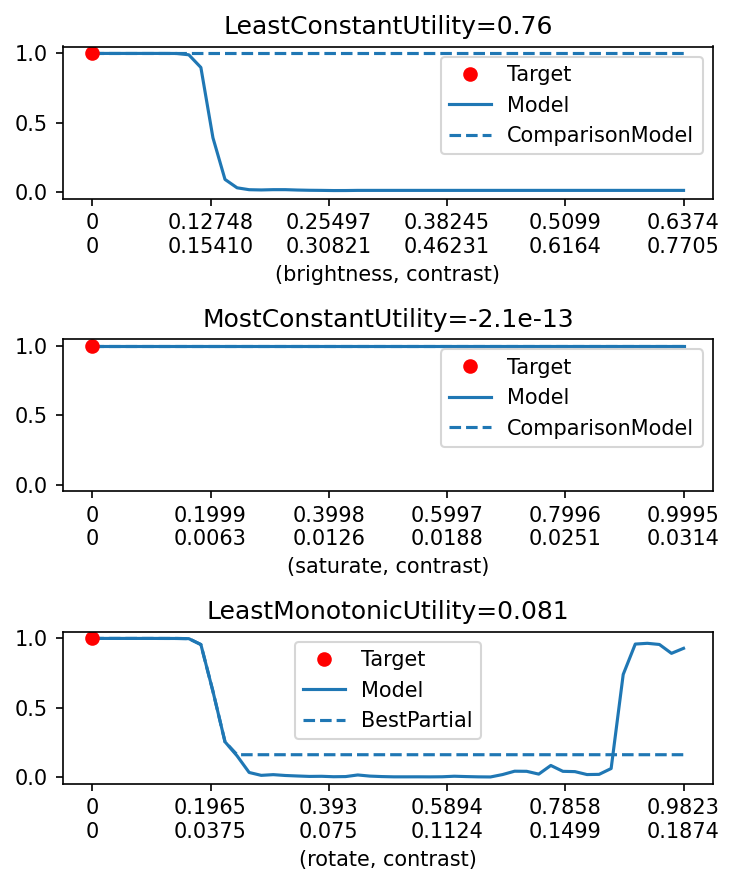

In [5]:
# Plot the best directions
f, axes = plt.subplots(3, 1, figsize=(5,6), dpi=150, sharey=True)
plot_curve_vals(best_least_const, utility=least_const_utility, feature_labels=curve_types, ax=axes[0], trans=True)
plot_curve_vals(best_most_const, utility=most_const_utility, feature_labels=curve_types, ax=axes[1], trans=True)
plot_curve_vals(best_mono, utility=mono_utility, feature_labels=curve_types, ax=axes[2], trans=True)
plt.tight_layout()

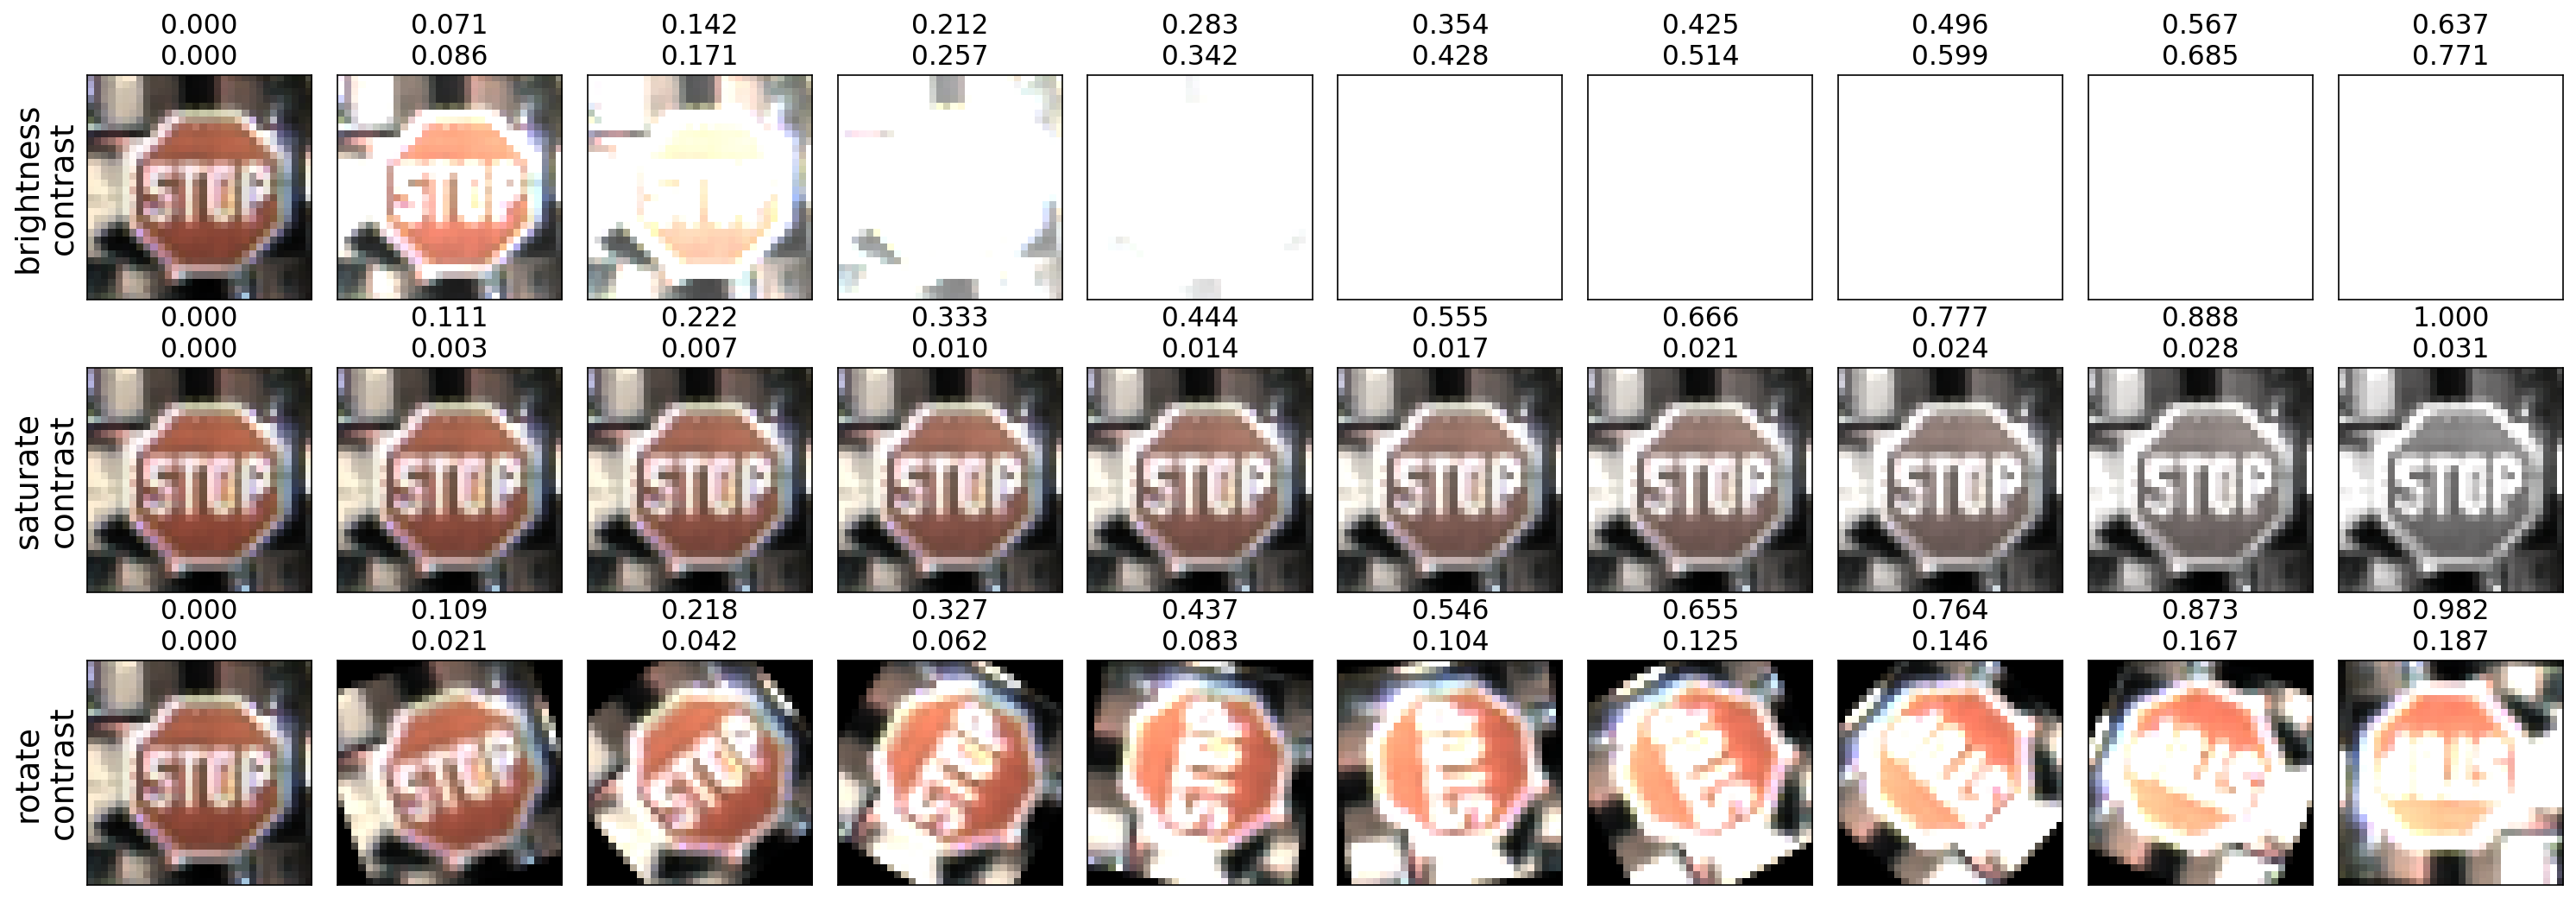

In [6]:
# Plot images along the directions
num_examples = 10
utils = [least_const_utility, most_const_utility, mono_utility]
curves = [best_least_const, best_most_const, best_mono]

f, axs = plt.subplots(len(curves), num_examples, figsize=(num_examples * 2, 2 * len(curves)+1), dpi=150)
for i, curve in enumerate(curves):
    idx = np.where(curve.v != 0)[0]
    curve_names = [curve_types[i] for i in idx]
    ylabel = '\n'.join(curve_names)
    t_vals = np.linspace(0, 1, num_examples)
    images = curve(t_vals).reshape(num_examples, 3, 32, 32)
    value_title = np.outer(t_vals, curve.v)
    for j in range(images.shape[0]):
        axs[i,j].imshow(images[j].transpose(1,2,0))
        axs[i,j].set_xticks(())
        axs[i,j].set_yticks(())
        axs[i,j].set_title('%0.3f\n%0.3f'%(value_title[j, idx][0], value_title[j, idx][1]), fontsize=15)
        if j == 0:
            axs[i,j].set_ylabel(ylabel, fontsize=18)
plt.tight_layout()